# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

54888


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc
import numpy as np

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}



# 2. Load codebook and chr2Zxys

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\postanalysis_vCW2_sorted'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load AB compartment and density ratio

## Load AB

Data can be generated using the notebook 

[4_compartment_analysis/2_ab_compartment_assignment_threshold_zero](../4_compartment_analysis/2_ab_compartment_assignment_threshold_zero.ipynb)

In [8]:
compartment_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis'
AB_id_fname = os.path.join(compartment_folder, r'AB_assignment_shared_ABth_zero.csv')

AB_id_summary = pd.read_csv(AB_id_fname, index_col=0)
AB_id_summary

,Astro,Endo,GABA,Gluta,Micro,Oligo
loci_name,,,,,,
chr1_3742742_3759944,B,B,B,B,B,B
chr1_6245958_6258969,A,B,B,B,B,B
chr1_8740008_8759916,B,B,B,B,B,B
chr1_9627926_9637875,A,B,B,B,A,B
chr1_9799472_9811359,A,B,B,B,A,A
...,...,...,...,...,...,...
chrX_163750534_163758706,A,A,A,A,A,A
chrX_166247682_166259932,A,A,A,A,A,A
chrX_167157164_167167452,A,A,A,A,A,A


## Load A/B density ratio

Data can be generated using the notebook 

[4_compartment_analysis/7_summarize_ab_trans_density_all_loci_subclass](../4_compartment_analysis/7_summarize_ab_trans_density_all_loci_subclass.ipynb)

In [9]:
# the calculated AB desnity ratio for single-cell
compartment_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis'
AB_summary_fname = os.path.join(compartment_folder, r'Median_Summary_trans_AB_ratio_notNorm_r0.5_bysubclass_th_zero.csv')

AB_ratio_summary = pd.read_csv(AB_summary_fname, index_col=0).transpose()
# remove chrY
AB_ratio_summary = AB_ratio_summary[:-1]
AB_ratio_summary

,Oligo,OPC,Micro,Astro,Endo,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L6 CT,L5/6 NP,L6b,Vip,Pvalb,Lamp5,Sst,Sncg
chr1_3742742_3759944,-0.422395,-0.336774,-0.278088,-0.489602,0.087817,-0.474198,-0.424039,-0.397661,-0.433375,-0.406431,-0.441964,-0.261607,-0.355470,-0.242751,-0.365409,-0.271475,-0.348622,-0.396724
chr1_6245958_6258969,-0.123587,-0.183419,-0.065169,-0.251864,0.346057,-0.384096,-0.395186,-0.374351,-0.342256,-0.363363,-0.392261,-0.175218,-0.197491,-0.301612,-0.214871,-0.229265,-0.127568,-0.257080
chr1_8740008_8759916,-0.384446,-0.052034,-0.286666,-0.411412,0.014480,-0.355418,-0.283315,-0.337409,-0.340426,-0.234319,-0.418353,-0.480288,-0.499484,0.005046,-0.199206,-0.062207,-0.122095,-0.540594
chr1_9627926_9637875,-0.229349,-0.036024,0.030728,-0.166186,0.244415,-0.300878,-0.238133,-0.336847,-0.161302,-0.240122,-0.237506,-0.296984,-0.294759,-0.280499,-0.201809,-0.023237,-0.200314,-0.325647
chr1_9799472_9811359,-0.079250,-0.062537,0.222733,-0.080703,0.478925,-0.249645,-0.248266,-0.203845,-0.208270,-0.187555,-0.207870,-0.272937,-0.285443,-0.315864,-0.393889,-0.104418,-0.167614,-0.507851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_163750534_163758706,-0.018650,0.014941,0.107204,0.217964,0.427682,-0.203048,-0.152021,-0.351594,-0.182704,-0.206527,-0.306559,-0.322240,-0.197656,-0.243480,-0.088580,-0.315339,-0.304985,-0.251397
chrX_166247682_166259932,0.227213,0.121523,0.065605,0.364292,0.309217,-0.056365,-0.012575,-0.208386,-0.175914,-0.006859,-0.067705,0.058149,0.053279,-0.145523,-0.236549,-0.223829,-0.154113,-0.555910
chrX_167157164_167167452,0.102458,-0.135584,0.430749,0.054695,0.556941,-0.123888,-0.062526,-0.143780,-0.118719,-0.155330,-0.107538,0.072693,-0.160688,0.084008,-0.043039,-0.279229,-0.138286,-0.334614
chrX_168746045_168757590,-0.134512,-0.316071,-0.007819,-0.168453,0.254124,-0.243110,-0.215402,-0.186746,-0.175388,-0.235237,-0.294560,0.249351,-0.281637,-0.231542,-0.059648,-0.344906,-0.176298,-0.444930


# 4. Load summarized radial position

Data can be generated by the notebook

[1_radial_position_convexhull_singlecell_dataframe](1_radial_position_convexhull_singlecell_dataframe.ipynb)

In [10]:
min_pts_th = 600
output_fname = os.path.join(output_analysis_folder, f'radial_pos_convexhull_median_summary_{min_pts_th}pts_bysubclass_v2.csv')

sorted_median_radial_pos_all = pd.read_csv(output_fname, index_col=0)
# remove chrY
sorted_median_radial_pos_all = sorted_median_radial_pos_all[~sorted_median_radial_pos_all.index.str.contains('chrY')]
sorted_median_radial_pos_all.head()

,chr,chr_order,norm_radial_position,total_cell,subclass
loci_name,,,,,
chr1_3742742_3759944,1,0,0.860136,1022.0,L2/3 IT
chr1_6245958_6258969,1,1,0.855358,969.0,L2/3 IT
chr1_8740008_8759916,1,2,0.850017,628.0,L2/3 IT
chr1_9627926_9637875,1,3,0.839728,960.0,L2/3 IT
chr1_9799472_9811359,1,4,0.826204,900.0,L2/3 IT


# 6. Convert to summary df

In [11]:
majorType_2_subclass_dict = {'Oligo':'Oligo', 'OPC':'Oligo',
                             'Micro':'Micro','Astro':'Astro','Endo':'Endo',
                             'L2/3 IT':'Gluta','L4/5 IT':'Gluta','L5 IT':'Gluta',
                             'L6 IT':'Gluta','L5 ET':'Gluta','L6 CT':'Gluta',
                             'L5/6 NP':'Gluta','L6b':'Gluta',
                             'Vip':'GABA','Pvalb':'GABA',
                             'Lamp5':'GABA','Sst':'GABA','Vip':'GABA','Sncg':'GABA',
                            }

In [12]:
# process
AB_summary_dict = {'AB_compartment':[],'AB_density_ratio':[],
                    'loci':[],'celltype':[],'chr':[],'norm_radial_position':[],'total_cell':[],}
for _group in np.unique(sorted_median_radial_pos_all['subclass']):
    # AB ratio
    if _group in AB_ratio_summary.columns:
        AB_summary_dict['AB_density_ratio'].extend(AB_ratio_summary[_group].tolist())
    else:
        AB_summary_dict['AB_density_ratio'].extend([np.nan]*len(AB_ratio_summary))
    # AB id
    if _group in majorType_2_subclass_dict.keys():
        _group_class = majorType_2_subclass_dict[_group]
        AB_summary_dict['AB_compartment'].extend(AB_id_summary[_group_class].tolist())
    else:
        AB_summary_dict['AB_compartment'].extend([np.nan]*len(AB_ratio_summary))   
    # other info            
    AB_summary_dict['loci'].extend(AB_ratio_summary.index.tolist())
    AB_summary_dict['celltype'].extend([_group]*len(AB_ratio_summary))
    AB_summary_dict['chr'].extend([i.split('_')[0] for i in AB_ratio_summary.index.tolist()])
    
    group_radial_pos_all = sorted_median_radial_pos_all[sorted_median_radial_pos_all['subclass']==_group]
    if len(group_radial_pos_all)==len(AB_ratio_summary):
        group_radial_pos_all = group_radial_pos_all.loc[AB_ratio_summary.index]
        radial_pos_list = group_radial_pos_all['norm_radial_position'].tolist()
        radial_N_list = group_radial_pos_all['total_cell'].tolist()
    else:
        radial_pos_list = [np.nan]*len(AB_ratio_summary)
        radial_N_list = [np.nan]*len(AB_ratio_summary)
        
    AB_summary_dict['norm_radial_position'].extend(radial_pos_list)
    AB_summary_dict['total_cell'].extend(radial_N_list)
    
    
AB_summary_df = pd.DataFrame(AB_summary_dict)
AB_summary_df

,AB_compartment,AB_density_ratio,loci,celltype,chr,norm_radial_position,total_cell
0,B,-0.489602,chr1_3742742_3759944,Astro,chr1,0.831239,1020.0
1,A,-0.251864,chr1_6245958_6258969,Astro,chr1,0.785055,807.0
2,B,-0.411412,chr1_8740008_8759916,Astro,chr1,0.836495,563.0
3,A,-0.166186,chr1_9627926_9637875,Astro,chr1,0.764242,826.0
4,A,-0.080703,chr1_9799472_9811359,Astro,chr1,0.750467,770.0
...,...,...,...,...,...,...,...
41596,A,-0.243480,chrX_163750534_163758706,Vip,chrX,0.792644,60.0
41597,A,-0.145523,chrX_166247682_166259932,Vip,chrX,0.814361,61.0
41598,A,0.084008,chrX_167157164_167167452,Vip,chrX,0.796547,54.0
41599,A,-0.231542,chrX_168746045_168757590,Vip,chrX,0.794884,51.0


# 7. Summarize correlation for chr, celltype, and modality

In [13]:
from scipy.stats import linregress, pearsonr, spearmanr

In [14]:
sel_cell_groups = np.unique(AB_summary_df['celltype'])
sel_cell_groups

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'OPC', 'Oligo', 'Peri',
       'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'], dtype=object)

## calculate correlation across chr, celltype for AB ratio

In [15]:
select_chroms_plot = [str(i) for i in range(1,20)]
select_chroms_plot.append('X')

#rna_col = 'rna_2000kb'
radial_activity_summary_dict = {'chr':[],'celltype':[],'target_mode':[], 'spearman_r':[], }
for rna_col in ['AB_density_ratio','AB_compartment']:
    for sel_chrom in select_chroms_plot:
        plot_df = AB_summary_df[AB_summary_df['chr']==f'chr{sel_chrom}']
        #selected_cell_labels = [c for c in selected_cell_labels if c in np.unique(plot_df['celltype'])]
        #plot_df = plot_df[plot_df['celltype'].isin(selected_cell_labels)]
        for _celltype in np.unique(plot_df['celltype']):
            sel_plot_df = plot_df[plot_df['celltype']==_celltype]
            r_value = spearmanr(sel_plot_df[rna_col],sel_plot_df['norm_radial_position'])
            radial_activity_summary_dict['spearman_r'].append(r_value[0])
            #r_value = pearsonr(sel_plot_df[rna_col],sel_plot_df['norm_radial_position'])
            #radial_activity_summary_dict['pearson_r'].append(r_value[0])

            radial_activity_summary_dict['chr'].append(sel_chrom)
            radial_activity_summary_dict['celltype'].append(_celltype)
            radial_activity_summary_dict['target_mode'].append(rna_col)


radial_activity_summary_df = pd.DataFrame(radial_activity_summary_dict)
radial_activity_summary_df.head()

C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,chr,celltype,target_mode,spearman_r
0,1,Astro,AB_density_ratio,-0.970488
1,1,Endo,AB_density_ratio,-0.959226
2,1,L2/3 IT,AB_density_ratio,-0.973192
3,1,L4/5 IT,AB_density_ratio,-0.975510
4,1,L5 ET,AB_density_ratio,-0.788194


## plot for RNA and ATAC for more celltypes included

In [16]:
#selected_cell_labels = np.unique(AB_summary_df['celltype'])
selected_cell_labels = ['L2/3 IT', 'L4/5 IT',  'L5 IT','L6 IT', #'L5/6 NP',
       'L5 ET', 'L6 CT', 'L6b',
           'Pvalb','Sst', 'Lamp5', 'Vip' , #'Sncg',
            'OPC', 'Oligo', 'Astro', 'Endo', 'Micro', 
                       ]

meta NOT subset; don't know how to subset; dropped


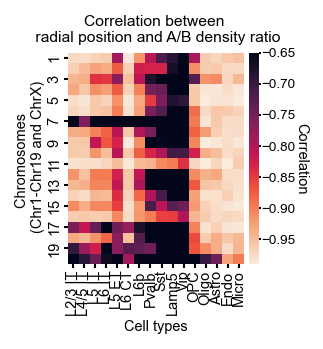

In [19]:
%matplotlib inline
for sel_mode_idx, sel_mode in enumerate(['AB_density_ratio',]):

    #sel_mode = 'H3K9me3'
    sel_radial_activity_summary_df = radial_activity_summary_df[radial_activity_summary_df['target_mode']==sel_mode]

    radial_activity_mat = sel_radial_activity_summary_df.pivot(index='chr',columns='celltype',values='spearman_r')
    radial_activity_mat = radial_activity_mat[selected_cell_labels]
    radial_activity_mat = radial_activity_mat.transpose()
    sorted_chroms = [str(i) for i in range(1,20)]
    sorted_chroms.append('X')
    radial_activity_mat = radial_activity_mat[sorted_chroms]
    radial_activity_mat = radial_activity_mat.transpose()

    fig,ax=plt.subplots(figsize=(_page_width/3,_page_width/3),dpi=150)

    #cbar_kws = dict(pad=.02)
    #boxprops = dict(linecolor='black')
    gfg = sns.heatmap(data=radial_activity_mat, #hue="chr",
                      #order=selected_cell_labels,
                      #hue_order=box_palette.keys(),
                       ax=ax, #cbar_kws = cbar_kws, 
                      cmap=sns.cm.rocket_r, vmin = -0.65, vmax = -0.9,
                      cbar_kws={'label':'Correlation', "pad": 0.02}
                 )

    ax.set_xlabel(f"Cell types", fontsize=_font_size-0.5, rotation=0,labelpad=2,)
    ax.set_ylabel(f"Chromosomes \n (Chr1-Chr19 and ChrX)", fontsize=_font_size-0.5, rotation=90,labelpad=1,)
    ax.tick_params('both',labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    #labeltop=False,
                    pad=1, )
    ax.figure.axes[-1].tick_params(axis='y', length=1, pad=0.1, labelsize=_font_size-1,rotation=0,)
    ax.figure.axes[-1].set_ylabel('Correlation', fontsize=_font_size-0.5, rotation=270, labelpad=6)

    TickLabels = radial_activity_mat.columns
    ax.set_xticks(np.arange(0,len(radial_activity_mat.columns))+0.5)
    ax.set_xticklabels(TickLabels,rotation=90,fontdict={'fontsize':_font_size-0.5})
    #plt.xticks(rotation=0)
    #plt.xlim([-1,20])
    #plt.ylim([-0.8,0.2])
    #select_chroms_plot = [str(i) for i in range(1,20)]
    #select_chroms_plot.append('X')
    #ax.set_xticks(np.arange(0,len(select_chroms_plot)))
    #TickLabels = select_chroms_plot
    #ax.set_xticklabels(TickLabels,rotation=0,fontdict={'fontsize':10})
    #ax.axhline(0.7, 0, 20, color='crimson', linestyle='dashed', linewidth=1.5)
    ax.grid(False)
    ax.set_title(f'Correlation between \n radial position and A/B density ratio', fontsize=_font_size, pad=5)

    #ax.set_yticklabels(TickLabels,rotation=0,fontdict={'fontsize':12})
    plt.savefig(os.path.join(output_figure_folder, f'Corr_of_radial_and_{rna_col}_matrix_sel_subclass.pdf'), 
                transparent=True, dpi=300, bbox_inches='tight') 
    plt.show()